In [1]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload

In [2]:
import equations as eq
reload (eq);
motion_folder = 'Abduction'
motion_name = 'abduction.mat'
struct_name = 'results_quat_EulInit150.mat'

model_struct = sc.io.loadmat('../Motions/'+motion_folder+'/OS_model.mat')
data_struct = sc.io.loadmat('../data_model.mat')
initPos = 'InitPosOptEul'
start = tm.time()
MM,FO,q,w,u0,fr,frstar,kinematical,xdot,holonomic = eq.create_eoms_u0state(model_struct,data_struct,initPos,derive = 'numeric')
TE,activations = eq.polynomials_quat(model_struct = model_struct,q = q,derive = 'numeric',model_params_struct = data_struct ,initCond_name = initPos)

time_to_create = tm.time() - start
print(time_to_create)

1253.4052879810333


In [3]:
import equations as eq
reload (eq);
# dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondQuat'].item()
x0t = list(x0.T[0])

In [4]:
eoms_implicit = sp.Matrix(kinematical).col_join(fr+frstar+TE).col_join(holonomic)

In [5]:
import trajectory_lib as tr
reload (tr);
num_nodes = 101
file = '../Motions/' + motion_folder + '/' + motion_name
traj, interval_value, time = tr.exp_trajectory_quat(file,num_nodes)

state_symbols = tuple(q+w+u0)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [6]:
traj_w = 150
vel_w = 0.1
act_w = 1


def obj(free):
    min_traj = traj_w * interval_value * np.sum((traj - free[:13*num_nodes])**2)
    min_vel = vel_w * interval_value * np.sum((free[13*num_nodes:num_states*num_nodes])**2)
    min_torque = act_w * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:13*num_nodes] = traj_w * 2.0 * interval_value * (free[:13*num_nodes] - traj)
    grad[13*num_nodes:num_states*num_nodes] = vel_w * 2 * interval_value * free[13*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = act_w * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [7]:
instance_constraints = []
# for i in range(13):
instance_constraints.append(state_symbols[-3].func(0.0)-0) 
    
bounds1 = (0.0,1.0)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [8]:
start = tm.time()
prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint')


time_to_create = tm.time() - start
print(time_to_create)



2340.7335119247437


In [9]:

prob.add_option('max_iter',3000)
# prob.add_option('limited_memory_max_history', 40)

In [10]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:13*num_nodes] = traj

In [11]:
time_2_solve_start = tm.time()
solution, info = prob.solve(initial_guess)
time_2_solve = tm.time() - time_2_solve_start
print(info['status_msg'])
print(info['obj_val'])
act_obj = np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
print('Objective activations: ', act_obj)

b'Algorithm stopped at a point that was converged, not to "desired" tolerances, but to "acceptable" tolerances (see the acceptable-... options).'
1.6906747100470374
Objective activations:  60.72552921018581


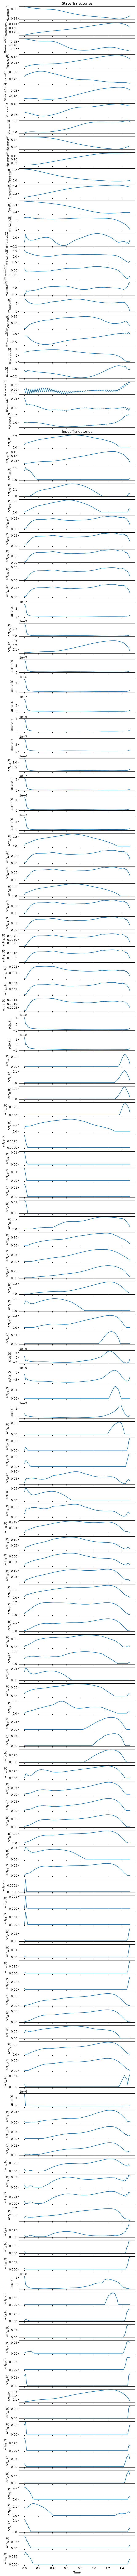

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

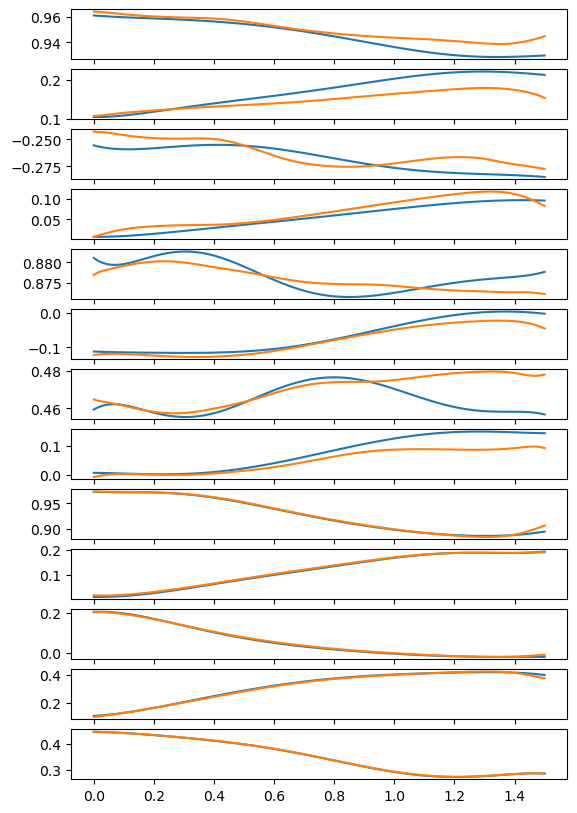

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(13)
for j in range(13):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

In [14]:
import trajectory_lib as tr
reload (tr);
file_name = '../Motions/'+motion_folder+'/'+struct_name
tr.sol2struct(solution,activations,len(q),num_states,num_nodes,time,time_2_solve,file_name)

Saved to .mat file


In [15]:
# import trajectory_lib as tr
# reload (tr);
# file_name = '../Motions/Abduction/results_quat.mat'
# tr.sol2struct(solution,activations,len(q),num_states,num_nodes,time,time_2_solve,file_name)

In [16]:
# import trajectory_lib as tr
# reload (tr);

# file_name_mot = '../Motions/Abduction/results_quat.mot'
# tr.sol2mot_quat(solution,num_nodes,13,time,file_name_mot)